In [153]:
# https://pyquantnews.com/the-1-thing-rentec-gets-right-rest-get-wrong/

In [154]:
# To find out noise in the signals

In [155]:
#!pip install TA-Lib
#!pip install yfinance as yf
#!pip install matplotlib

In [156]:
from math import pi

from scipy.signal import butter, filtfilt
import numpy as np
import talib as ta_lib
import matplotlib.pyplot as plt
import yfinance as yf

#from openbb_terminal.sdk import openbb

In [157]:
# Use OpenBB to download the EUR/USD price and get the returns.

In [158]:
list10=['TSLA']#, 'ABNB', 'CL', 'CTLT', 'ORCL'] 
data =  yf.download(list10, period="1y", interval ="1d")
prices = (
    data["Adj Close"]
    .to_frame()
    .rename(
        columns={
            "Adj Close": "close"
        }
    )
)

prices["log_return"] = (
    prices.close
    .apply(np.log)
    .diff(1)
)

[*********************100%***********************]  1 of 1 completed


In [159]:
# Build the cycle model and filter

In [160]:

#The first step is to find the dominant phase of the time series using the Hilbert Transform,
#then use it to model a cycle inefficiency in the market.

#Next is the dominant cycle period which is a signal processing technique that isolates the most 
#significant patterns in prices.


In [161]:
# Hilbert Transform - Dominant Cycle Phase
prices["phase"] = ta_lib.HT_DCPHASE(prices.close)

# Convert into a wave using a cycle model
prices["signal"] = np.sin(prices.phase + pi / 4)

# Use the Hilbert Transform - Dominant Cycle Period
prices["period"] = ta_lib.HT_DCPERIOD(prices.close)

In [162]:
# This code calculates the dominant cycle, a modeled signal from the prices, and the dominant cycle period.

#Next, create the bandpass filter

In [163]:
def butter_bandpass(data, period, delta=0.5, fs=5):
    nyq = 0.5 * fs

    # Low cutoff frequency
    low = 1.0 / (period * (1 + delta))
    low /= nyq

    # High cutoff frequency
    high = 1.0 / (period * (1 - delta))
    high /= nyq

    b, a = butter(2, [low, high], btype="band")

    return filtfilt(b, a, data)

def roll_apply(e):
    close = prices.close.loc[e.index]
    period = prices.period.loc[e.index][-1]
    out = butter_bandpass(close, period)
    return out[-1]

In [164]:
#The Butterworth filter is designed to have a frequency response that is as flat as possible in the passband.

#You can use it as a bandpass filter centered around the dominant cycle period.

#Pandas cannot create a rolling calculation with two variables, so you need a helper function.

#Now it’s time to filter the data and measure the amplitude.

In [165]:
prices["filtered"] = (prices.dropna().rolling(window=30).apply(lambda series: roll_apply(series), raw=False).iloc[:, 0])

prices["amplitude"] = (prices.filtered.rolling(window=30).apply(lambda series: series.max() - series.min() ))

prices["ema_amplitude"] = (ta_lib.EMA(prices.amplitude,timeperiod=30))

In [166]:
# In the first function, you apply the bandpass filter to a rolling window of price data.
#This only lets the strongest signals found in the price data through.

#When the smoothed amplitude is at a peak or valley, the maket is showing signs
#that the market inefficiency you modeled is present and should be traded.

In [167]:
# Analyze the results

In [168]:
signal_thresh = 0.75
amp_thresh = 0.004  # 40 pips

prices["position"] = 0
prices.loc[(prices.signal >= signal_thresh) & (prices.amplitude > amp_thresh), "position"] = -1
prices.loc[(prices.signal <= -signal_thresh) & (prices.amplitude > amp_thresh), "position"] = 1

In [169]:
# In practice, both the signal and amplitude threshold can (and should) be modeled and optimized.

#To visualize what’s going on, plot it.

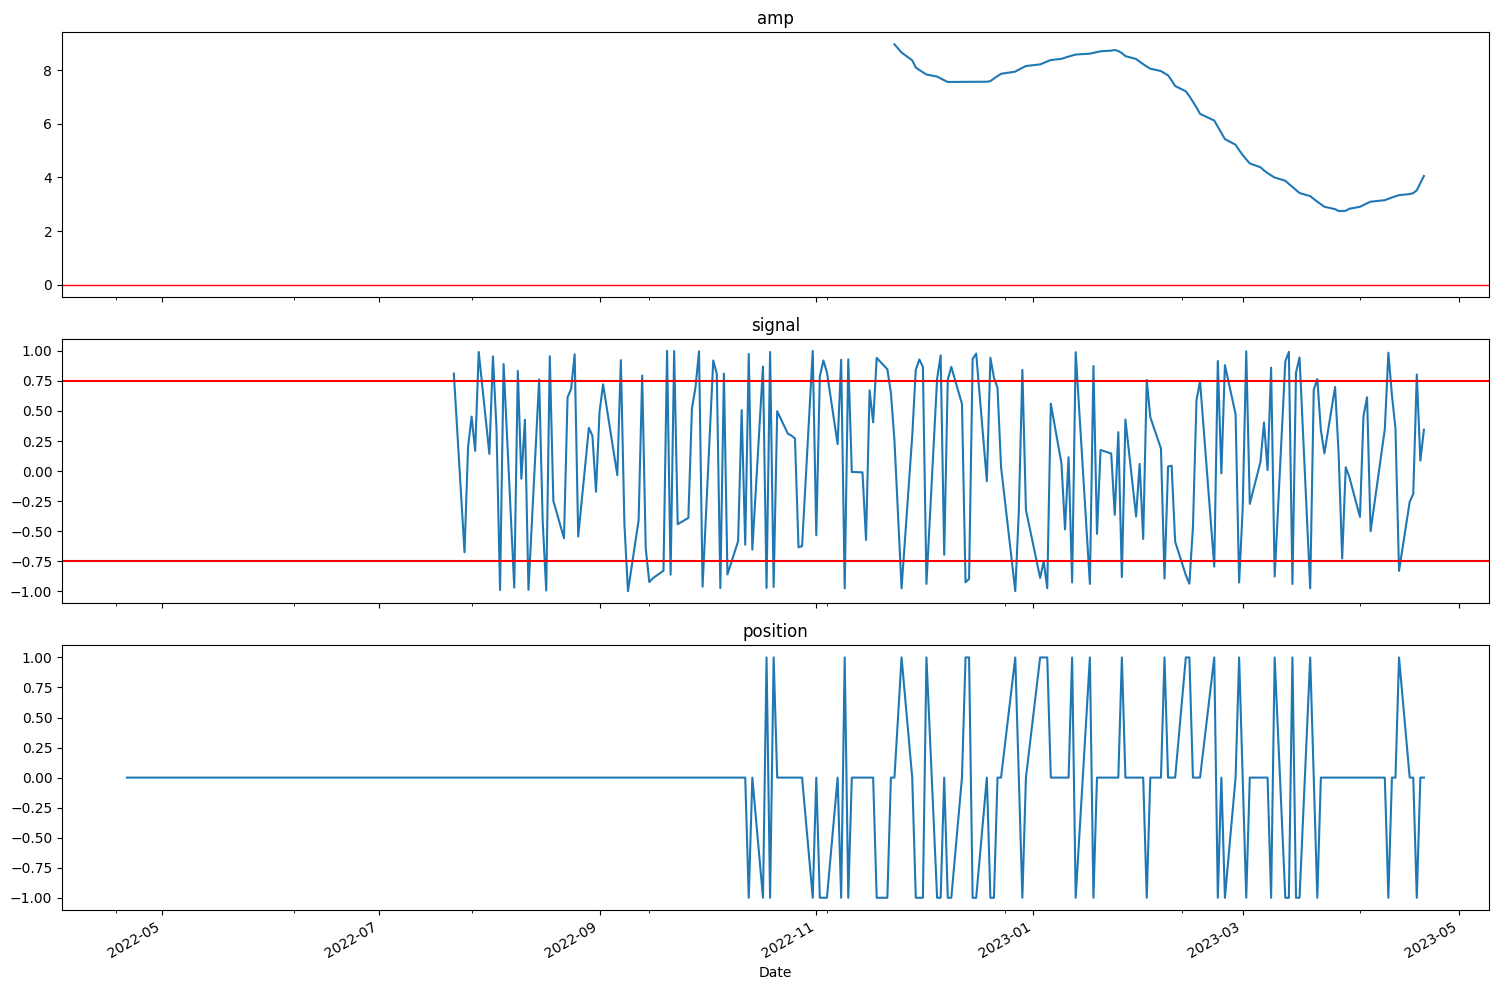

In [170]:
fig, axes = plt.subplots(
    nrows=3,
    figsize=(15, 10),
    sharex=True
)

prices.ema_amplitude.plot(ax=axes[0],title="amp"
)
axes[0].axhline(
    amp_thresh,
    lw=1,
    c="r"
)
prices.signal.plot(
    ax=axes[1],
    title="signal"
)
axes[1].axhline(
    signal_thresh,
    c="r"
)
axes[1].axhline(
    -signal_thresh,
    c="r"
)
prices.position.plot(
    ax=axes[2],
    title="position"
)
fig.tight_layout()

In [171]:
# The top chart is the amplitude of the filtered prices and is used to determine when the market inefficiency exists.

#The second chart is the signal which oscillates between -1 and 1. In this example, the signal is a cycle model of market prices.

#I use a naive strategy of entering short when the signal exceeds 0.75 and entering long when the signal goes below -0.75.

#The last chart shows the position either long (1), short (-1), or flat.

In [172]:
prices.tail(25)

,close,log_return,phase,signal,period,filtered,amplitude,ema_amplitude,position
Date,,,,,,,,,
2023-03-17,180.130005,-0.021963,265.010771,0.945526,37.769225,0.414328,1.747601,3.421750,-1
2023-03-20,183.250000,0.017173,286.892006,-0.975530,36.168881,0.344271,1.639296,3.306753,1
2023-03-21,197.580002,0.075292,314.115644,0.675599,34.379660,-0.121873,1.639296,3.199175,0
2023-03-22,191.149994,-0.033085,-25.045666,0.765921,32.765046,-0.247733,1.639296,3.098538,-1
2023-03-23,192.220001,0.005582,-6.720092,0.341480,31.557654,-0.349226,1.639296,3.004393,0
2023-03-24,190.410004,-0.009461,11.928656,0.147147,30.431574,-0.210028,1.519256,2.908578,0
2023-03-27,191.809998,0.007326,26.714079,0.699614,29.186477,-0.433017,1.519256,2.818944,0
2023-03-28,189.190002,-0.013753,39.911930,0.142885,27.859705,-1.193474,1.719282,2.747998,0
2023-03-29,193.880005,0.024488,53.436652,-0.727708,26.593592,-2.296645,2.822454,2.752802,0


In [173]:
#2023-04-20 14:30:00-04:	76.180000	-0.001312	141.398800	-0.726029	15.267722	-0.090118	0.392080	0.343374	0
#2023-04-20 15:30:00-04:00	76.360001	0.002360	156.031412	-0.259807	15.330300	-0.092495	0.392080	0.346517	0